In [2]:
from DLtools.Data_preprocess import series_to_supervised,load_data,manual_trian_test_split

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean()
df_w = rw.water_df
df_r = rw.rain_df

DataFrame shape: (465169, 35)


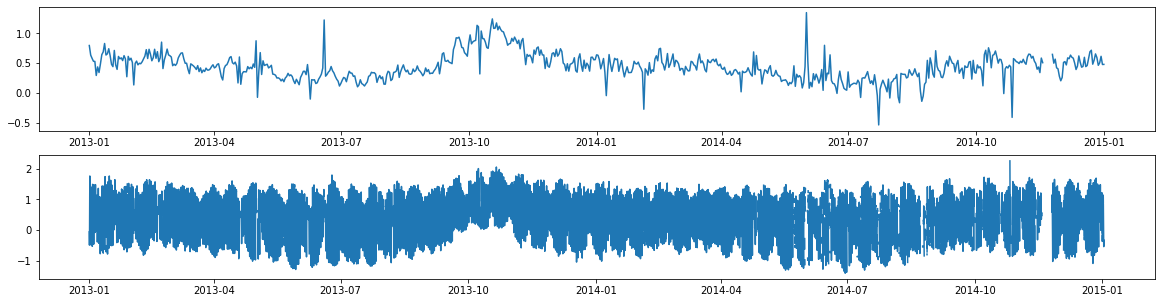

In [6]:
fig,ax =plt.subplots(2,1,figsize=(20,5))
ax[0].plot(df['CPY015_w']['2013-01-01':'2015-01-01'])
ax[1].plot(df_w['CPY015_w']['2013-01-01':'2015-01-01'])

# Preprocessing

In [8]:
X = df['CPY015_w']['2013-01-01':'2015-01-01'].interpolate(limit=7).values
X = X.astype('float32')

In [10]:
LOOKBACK = 7
Xtrain,Ytrain,Xtest,Ytest = manual_trian_test_split(X,LOOKBACK)
print(Xtrain.shape,Ytrain.shape)
print(Xtest.shape,Ytest.shape)

Shape of train:... (503, 7) (503,)
Shape of test:... (212, 7) (212,)
(503, 7) (503,)
(212, 7) (212,)


# MLP

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [14]:
EPOCH = 100
BATCH = 2
VALIDATION = (Xtest,Ytest)

In [16]:
model = Sequential()
model.add(Dense(8, input_dim=LOOKBACK, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(Xtrain, Ytrain, epochs=EPOCH, batch_size=BATCH, verbose=1,shuffle=False,validation_data=VALIDATION)


Epoch 1/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0296
Epoch 2/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0298
Epoch 3/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0169 - val_loss: 0.0295
Epoch 4/100
252/252 [==============================] - 1s 3ms/step - loss: 0.0169 - val_loss: 0.0293
Epoch 5/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0299
Epoch 6/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0297
Epoch 7/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0299
Epoch 8/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0298
Epoch 9/100
252/252 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0300
Epoch 10/100
252/252 [==============================] - 1s 2ms/step - loss: 0.0168 - val_lo

In [20]:
# Estimate model performance
trainScore = model.evaluate(Xtrain, Ytrain, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(Xtest, Ytest, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.02 MSE (0.13 RMSE)
Test Score: 0.03 MSE (0.17 RMSE)


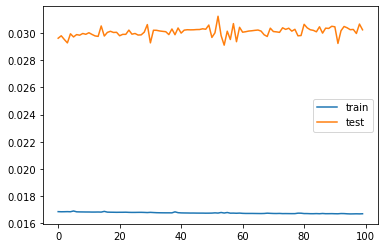

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
# generate predictions for training
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)

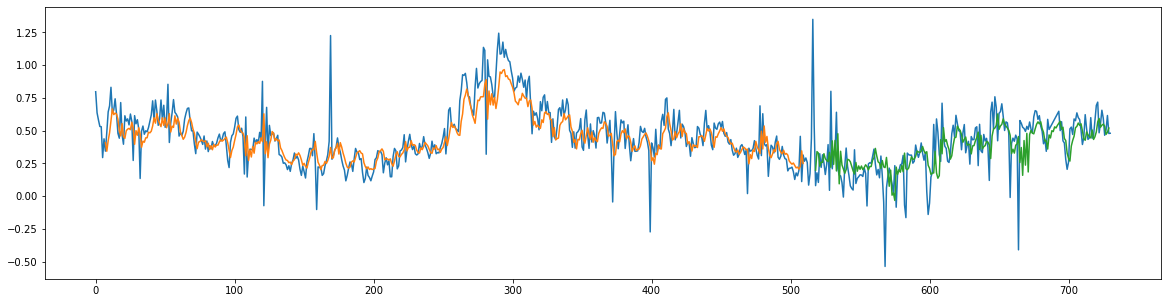

In [26]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(X.reshape(-1,1))
trainPredictPlot[:] = np.nan
trainPredictPlot[LOOKBACK:len(trainPredict)+LOOKBACK, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(X.reshape(-1,1))
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(LOOKBACK*2)+1:len(X)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,5))
plt.plot(X)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()